In [1]:
library(mmge)
library(expm)
library(MASS)

Loading required package: Matrix

Attaching package: ‘expm’

The following object is masked from ‘package:Matrix’:

    expm



In [2]:
devtools::reload(pkg=".")

ℹ Reloading attached mmge


In [56]:
m = 5
n = 5
p = 100
q = 30

# 1. generate the common graph structure

In [57]:
Adj.S = matrix(0, q, q)
Adj.S[upper.tri(Adj.S)] = rbinom(q*(q-1)/2, 1, sqrt(3/q)) 
Adj.S = Adj.S + t(Adj.S)

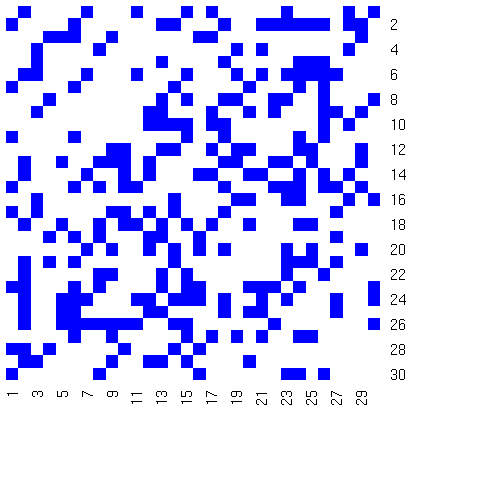

In [58]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)

# 2. generate precision matrices

In [59]:
power.S = 0.3
power.T = 0.2
decay.T = 1

In [60]:
Omega.S = lapply(rep(0,m), function(x){
    Omega = matrix(0,q,q)
    Omega[upper.tri(Omega)] = (
        runif(q*(q-1)/2,0, power.S) * Adj.S[upper.tri(Adj.S)])
    Omega = Omega + t(Omega)
    if(min(eigen(Omega)$values)<0){
        Omega = Omega - 2*min(eigen(Omega)$values)*diag(q)
    }
    return(Omega)
})
Sigma.S = lapply(Omega.S, solve)

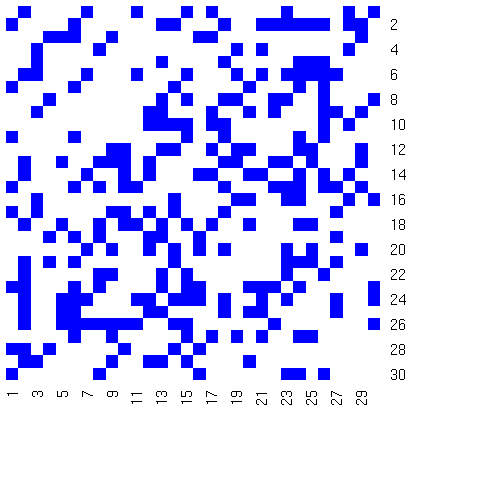

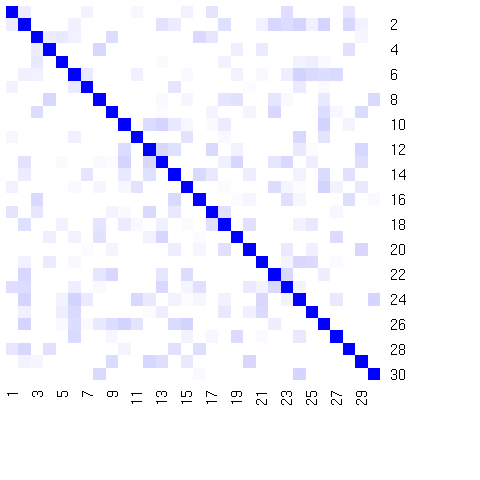

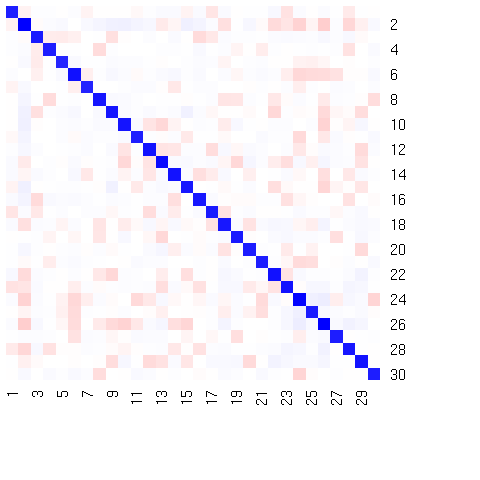

In [61]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(Omega.S[[1]])
imshow(Sigma.S[[1]])

In [62]:
beta.T = power.T * abs(outer(1:p,1:p,FUN='-'))**(-1-decay.T)
beta.T[upper.tri(beta.T, diag=TRUE)] = 0

In [63]:
Omega.T = lapply(rep(0, m), function(x){
    t(diag(p)-beta.T) %*% (diag(p)-beta.T)})
Sigma.T = lapply(Omega.T, solve)

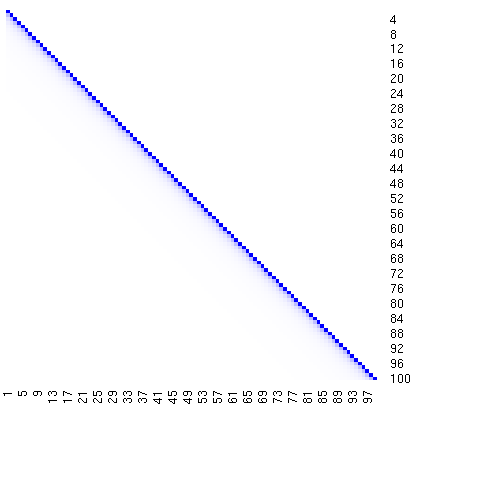

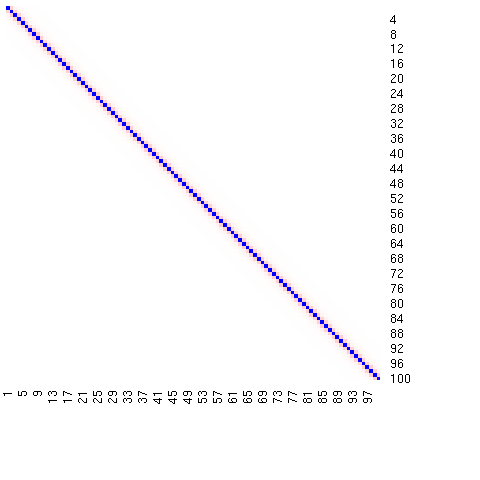

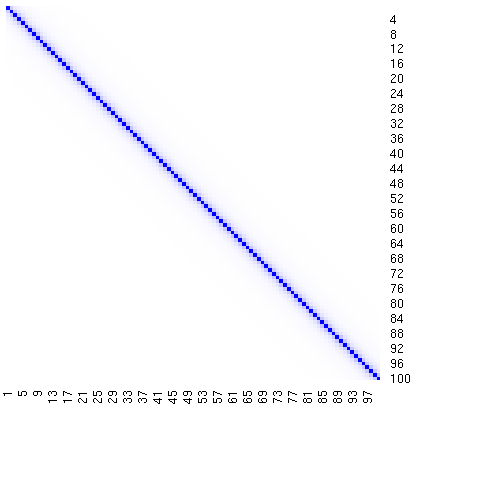

In [64]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(beta.T)
imshow(Omega.T[[1]])
imshow(Sigma.T[[1]])

# 3. simulate data acoording to MGGM

In [65]:
data = lapply(1:m, function(l){
    n_l = n #floor(runif(1, n, 2*n))
    return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
        sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
    }), c(p,q,n_l)))
})

In [66]:
ns = sapply(data, function(x){dim(x)[3]})

In [67]:
sess.id = c(sapply(1:m, function(l){rep(l,ns[l])}))

# 4. estimation by the proposed method

In [162]:
alphas = c(c(0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.025),
           seq(0.1, 1.0, length.out=10))
lambdas = c(1, 1e-2, 1e-4, 1e-6)

In [164]:
est.T = est.temporal(data, order.T=5)

In [165]:
est.S = est.spatial(data, lambdas=lambdas)

In [166]:
inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)

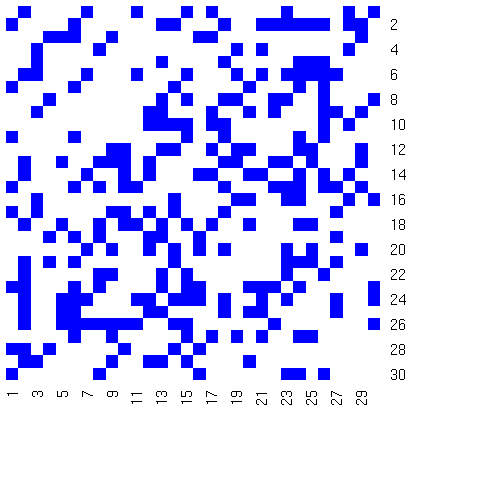

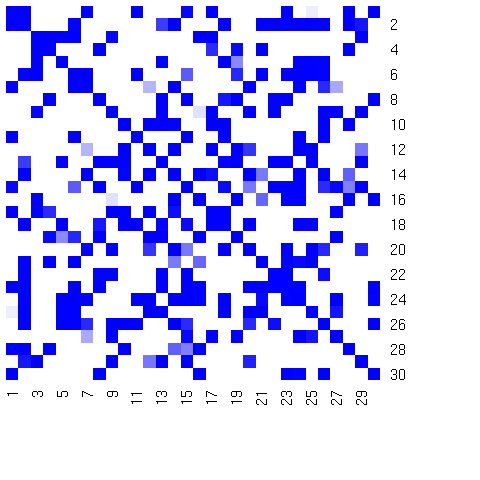

In [167]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(inf.S$p.value[,,2], col=BlWh.colors(), vmin=0, vmax=0.1)

In [168]:
A.hat.S = array(sapply(alphas, function(a){
    A.hat = inf.S$p.value < a
    A.hat[diag(q)==1] = FALSE
    return(A.hat)
}), c(q, q, length(lambdas), length(alphas)))

In [176]:
NTP.S = apply(c(Adj.S) & A.hat.S, c(3,4), function(A){
    sum(A[diag(q)!=1])
})

In [177]:
NFP.S = apply(c(!Adj.S) & A.hat.S, c(3,4), function(A){
    sum(A[diag(q)!=1])
})

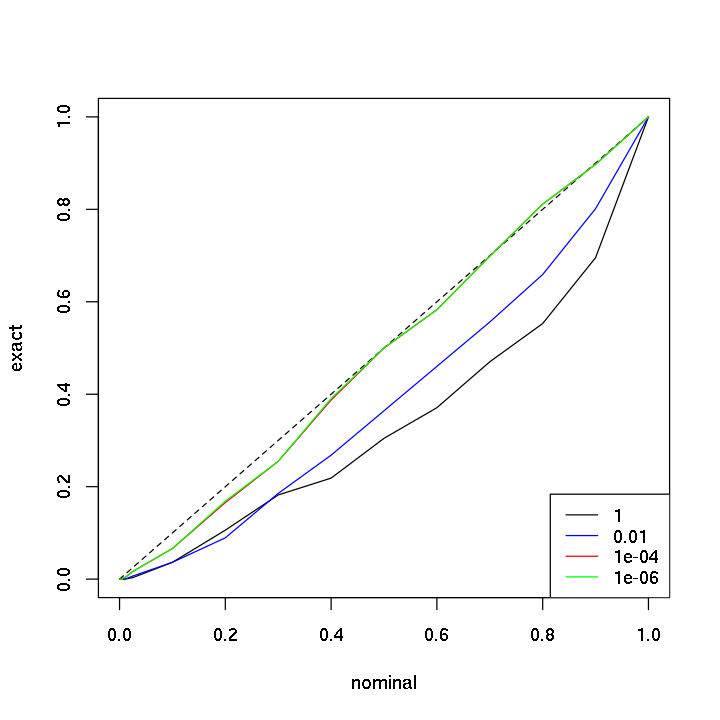

In [178]:
options(repr.plot.width=6, repr.plot.height=6)
plot(alphas, alphas, type='l', lty=2, xlab="nominal", ylab="exact")
lines(alphas, NFP.S[1,]/sum(!Adj.S[diag(q)!=1]), col='black')
lines(alphas, NFP.S[2,]/sum(!Adj.S[diag(q)!=1]), col='blue')
lines(alphas, NFP.S[3,]/sum(!Adj.S[diag(q)!=1]), col='red')
lines(alphas, NFP.S[4,]/sum(!Adj.S[diag(q)!=1]), col='green')
legend('bottomright', legend=lambdas, lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

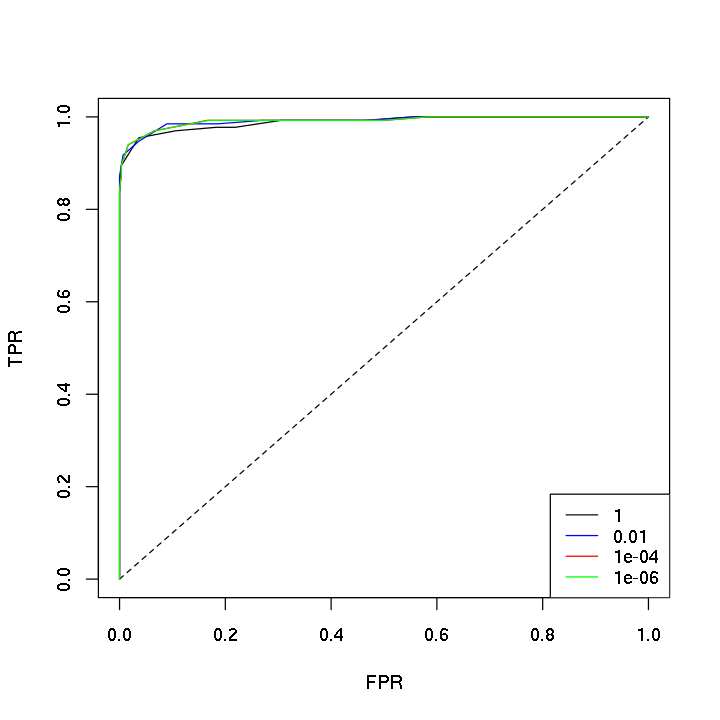

In [180]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(NFP.S[1,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.S[1,]/sum(Adj.S[diag(q)!=1]), col='black')
lines(NFP.S[2,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.S[2,]/sum(Adj.S[diag(q)!=1]), col='blue')
lines(NFP.S[3,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.S[3,]/sum(Adj.S[diag(q)!=1]), col='red')
lines(NFP.S[4,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.S[4,]/sum(Adj.S[diag(q)!=1]), col='green')
legend('bottomright', legend=lambdas, lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

# 5. estimation by other methods

## Zhu & Li. (2018).

To operate R function `MGGM.path` from software `matrix_grouping` by Zhu & Li (2018), DLL file `/EXTERNAL/matrix_grouping/lib/c_funcs.so` should be loaded. The DLL file can be obtained by compiling C codes in `/EXTERNAL/matrix_grouping/src/`. Run command `make` in `/EXTERNAL/matrix_grouping/` to compile the codes. If the DLL file is not executable, try to recompile by running `make clean` and then `make`.

In [79]:
dyn.load("../EXTERNAL/matrix_grouping/lib/c_funcs.so")
source("../EXTERNAL/matrix_grouping/src/R/MGGM.R")

In [122]:
lambdas1 <- log(p)*c(0.2, 0.1, 0.08, 0.05, 0.02, 0.01, 0.005, 0.002, 0) #lasso penlaty
lambdas2 <- log(p)*c(.1, .08, .06, .05, .04, .03, .0) #grouping penalty

In [123]:
# matrix specifying pairs of precision matrices to be penalized to be similar
graph.zl = t(which(sapply(1:m, function(x){x > (1:m)}), arr.ind=TRUE)) - 1

In [124]:
# generating sample covariance matrices 
S.bar.S = lapply(1:m, function(l){
    cor(array(aperm(data[[l]], c(1,3,2)), c(p*ns[l], q)))
})

In [125]:
# run software by Zhu & Li (2018)
ret.zl = MGGM.path(array(unlist(S.bar.S), c(q,q*m)), ns*p, 
                   lambdas1, lambdas2, graph.zl, tau=0.1,
                   MAX_iter=50, eps_mat = 1e-2, loaded=TRUE)

In [126]:
# estimated spatial precision matrices
W.hat.zl = lapply(1:m, function(l){
    array(ret.zl$sol_nonconvex, 
          c(q,q,m,length(lambdas2),length(lambdas1)))[,,l,,]
})

In [127]:
# score = Reduce(f='+', lapply(1:m, function(l){
#     apply(W.hat.zl[[l]], c(3,4), function(W){
#         sum(S.bar.S[[l]]*W) - log(det(W))
#     })
# }), accumulate=FALSE)

In [148]:
A.hat.zl = lapply(W.hat.zl, function(W){
    A.hat = (abs(W) > 1e-5)
    A.hat[diag(q)==1] = FALSE
    return(1 * A.hat)
})

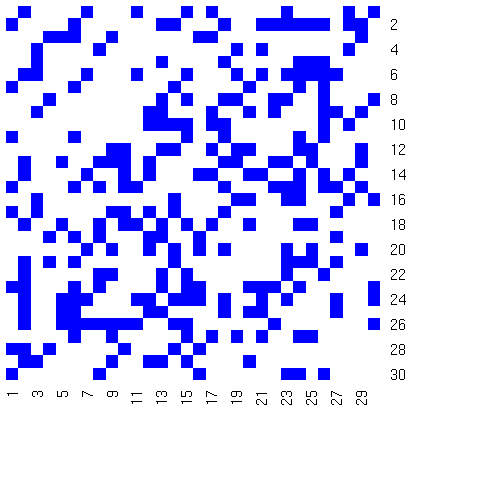

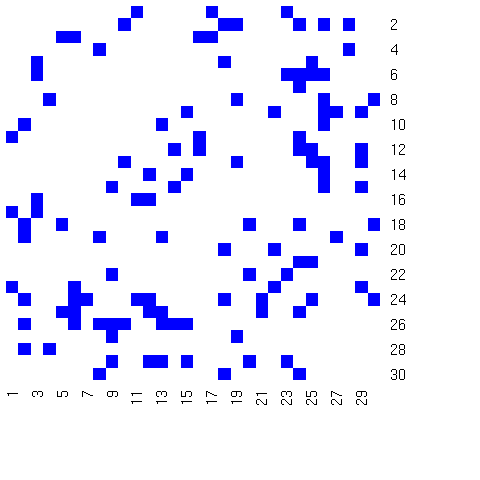

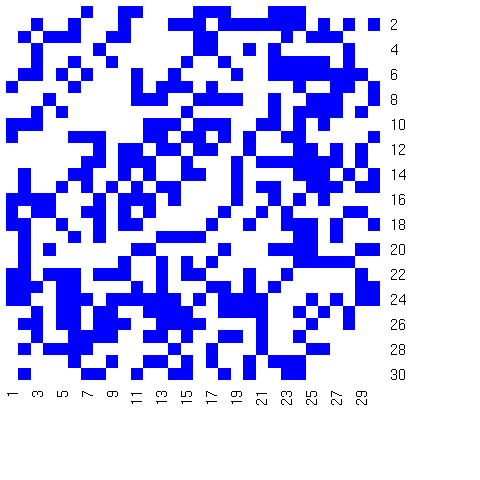

In [242]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(A.hat.zl[[1]][,,2,4])
imshow(A.hat.zl[[1]][,,2,5])

In [181]:
NTP.zl = Reduce(f='+', lapply(A.hat.zl, function(A){
    apply(c(Adj.S) & A, c(3,4), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

In [182]:
NFP.zl = Reduce(f='+', lapply(A.hat.zl, function(A){
    apply(c(!Adj.S) & A, c(3,4), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

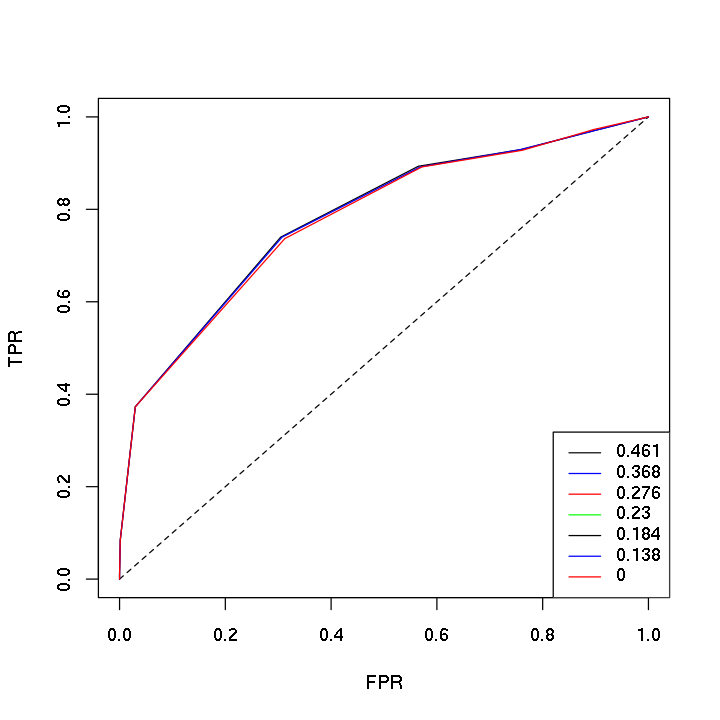

In [183]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(NFP.zl[1,]/sum(!Adj.S[diag(q)!=1])/m,
      NTP.zl[1,]/sum(Adj.S[diag(q)!=1])/m, col='black')
lines(NFP.zl[2,]/sum(!Adj.S[diag(q)!=1])/m, 
      NTP.zl[2,]/sum(Adj.S[diag(q)!=1])/m, col='blue')
lines(NFP.zl[3,]/sum(!Adj.S[diag(q)!=1])/m, 
      NTP.zl[3,]/sum(Adj.S[diag(q)!=1])/m, col='red')
# lines(NFP.S[4,]/sum(!Adj.S), NTP.S[4,]/sum(Adj.S), col='green')
legend('bottomright', legend=round(lambdas2,digits=3), lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

## Vector-variate methods

For brevity of this notebook, the implementations of the baseline vector-variate methods are relegated to `/EXTERNAL/vector_variate_methods.R`, and we call them by wrapper functions `est.spatial.rkfl`, `est.spatial.cllx`, and `est.spatial.ll`. `est.spatial.rkfl` requires package `HGSL` in fitting Heterogeneous Group Square-root Lasso, where `est.spatial.cllx` and `est.spatial.ll` require package `CVXR` in solving the optimization problems. Also, the temporal correlation across spatial vector-variate samples are whitened, which is done by package `whitening`.

In [240]:
source('../EXTERNAL/vector_variate_methods.R')

In [215]:
# Whitening temporal correlation for vector-variate methods
data.whiten = whiten.per.session(data)

## Ren et al. (2019).

In [216]:
alphas = c(c(0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.025),
           seq(0.1, 1.0, length.out=10))
lambdas = c(1, 1e-2, 1e-4, 1e-6)

In [217]:
est.S.rkfl = est.spatial.rkfl(data.whiten, lambdas=lambdas)

In [218]:
inf.S.rkfl = inf.single.rkfl(est.S.rkfl$W.hat.S, ns*p)

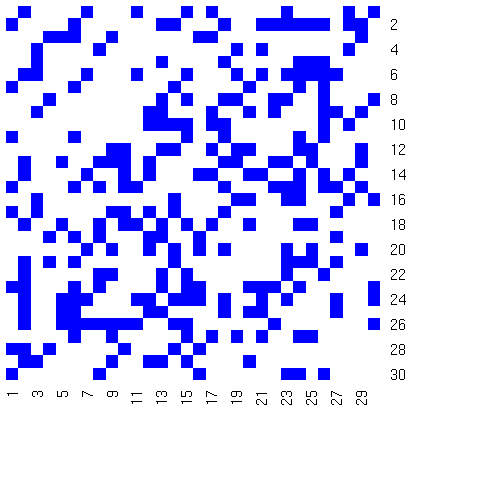

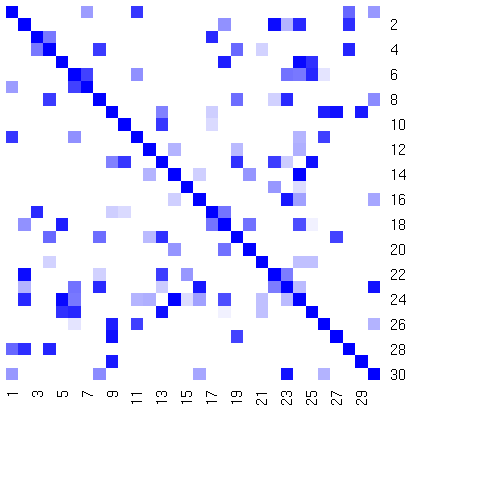

In [219]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(inf.S.rkfl$p.value[,,2], col=BlWh.colors(), vmin=0, vmax=0.1)

In [220]:
A.hat.rkfl = array(sapply(alphas, function(a){
    A.hat = inf.S.rkfl$p.value < a
    A.hat[diag(q)==1] = FALSE
    return(A.hat)
}), c(q, q, length(lambdas), length(alphas)))

In [221]:
NTP.rkfl = apply(c(Adj.S) & A.hat.rkfl, c(3,4), function(A){
    sum(A[diag(q)!=1])
})

In [222]:
NFP.rkfl = apply(c(!Adj.S) & A.hat.rkfl, c(3,4), function(A){
    sum(A[diag(q)!=1])
})

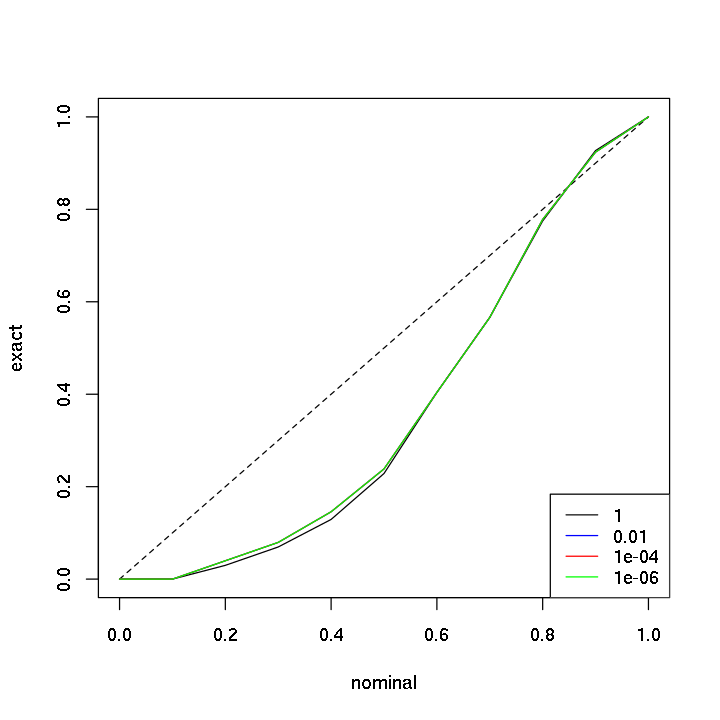

In [223]:
options(repr.plot.width=6, repr.plot.height=6)
plot(alphas, alphas, type='l', lty=2, xlab="nominal", ylab="exact")
lines(alphas, NFP.rkfl[1,]/sum(!Adj.S[diag(q)!=1]), col='black')
lines(alphas, NFP.rkfl[2,]/sum(!Adj.S[diag(q)!=1]), col='blue')
lines(alphas, NFP.rkfl[3,]/sum(!Adj.S[diag(q)!=1]), col='red')
lines(alphas, NFP.rkfl[4,]/sum(!Adj.S[diag(q)!=1]), col='green')
legend('bottomright', legend=lambdas, lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

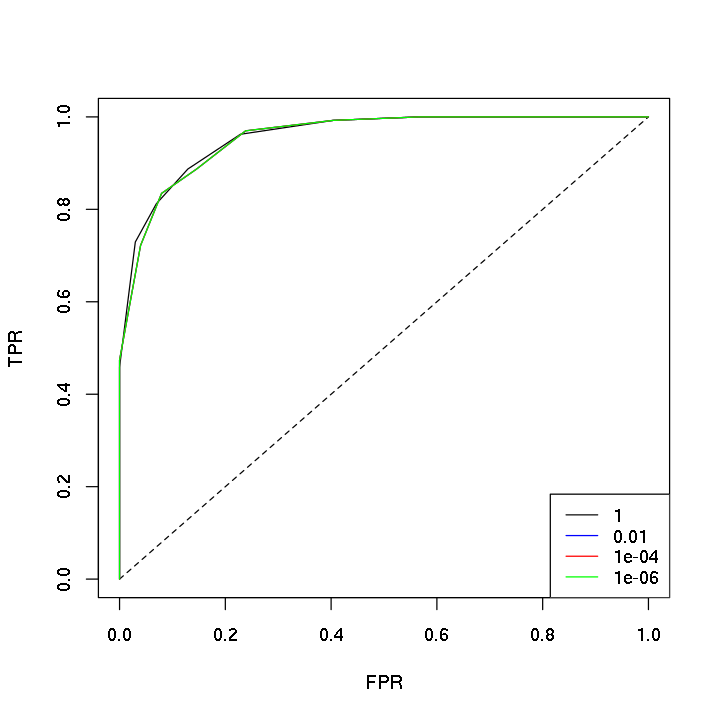

In [230]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(NFP.rkfl[1,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.rkfl[1,]/sum(Adj.S[diag(q)!=1]), col='black')
lines(NFP.rkfl[2,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.rkfl[2,]/sum(Adj.S[diag(q)!=1]), col='blue')
lines(NFP.rkfl[3,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.rkfl[3,]/sum(Adj.S[diag(q)!=1]), col='red')
lines(NFP.rkfl[4,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.rkfl[4,]/sum(Adj.S[diag(q)!=1]), col='green')
legend('bottomright', legend=lambdas, lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

## Cai et al. (2016).

In [247]:
lambdas = log(p)*c(0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1)/m

In [248]:
est.S.cllx = est.spatial.cllx(data.whiten, lambdas, verbose=TRUE)

lambda: 0.000921034 
spatial estimation using CVXR at i= 1 
spatial estimation using CVXR at i= 2 
spatial estimation using CVXR at i= 3 
spatial estimation using CVXR at i= 4 
spatial estimation using CVXR at i= 5 
spatial estimation using CVXR at i= 6 
spatial estimation using CVXR at i= 7 
spatial estimation using CVXR at i= 8 
spatial estimation using CVXR at i= 9 
spatial estimation using CVXR at i= 10 
spatial estimation using CVXR at i= 11 
spatial estimation using CVXR at i= 12 
spatial estimation using CVXR at i= 13 
spatial estimation using CVXR at i= 14 
spatial estimation using CVXR at i= 15 
spatial estimation using CVXR at i= 16 
spatial estimation using CVXR at i= 17 
spatial estimation using CVXR at i= 18 
spatial estimation using CVXR at i= 19 
spatial estimation using CVXR at i= 20 
spatial estimation using CVXR at i= 21 
spatial estimation using CVXR at i= 22 
spatial estimation using CVXR at i= 23 
spatial estimation using CVXR at i= 24 
spatial estimation using CVX

spatial estimation using CVXR at i= 24 
spatial estimation using CVXR at i= 25 
spatial estimation using CVXR at i= 26 
spatial estimation using CVXR at i= 27 
spatial estimation using CVXR at i= 28 
spatial estimation using CVXR at i= 29 
spatial estimation using CVXR at i= 30 


In [249]:
A.hat.cllx = lapply(est.S.cllx$W.hat.S, function(W){
    A.hat = (abs(W) > 1e-5)
    A.hat[diag(q)==1] = FALSE
    return(1 * A.hat)
})

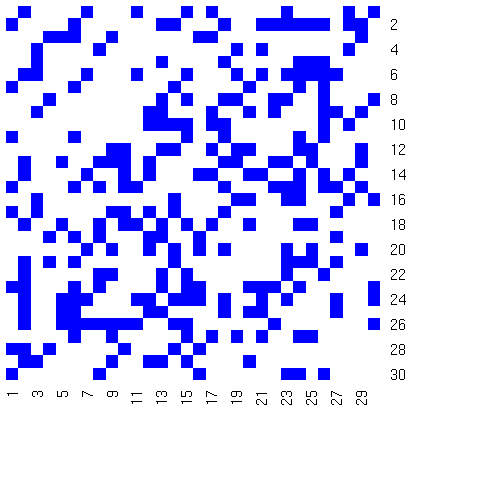

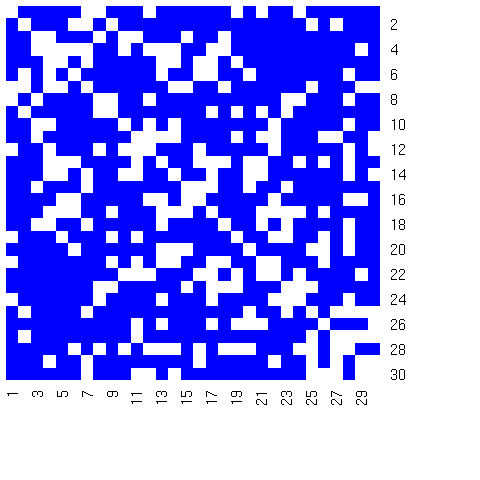

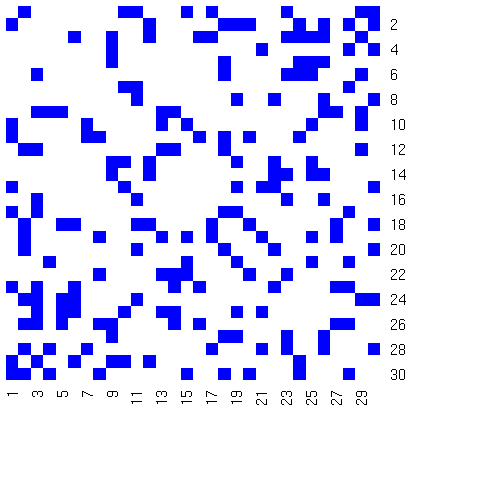

In [252]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(A.hat.cllx[[1]][,,4])
imshow(A.hat.cllx[[1]][,,5])

In [254]:
NTP.cllx = Reduce(f='+', lapply(A.hat.cllx, function(A){
    apply(c(Adj.S) & A, c(3), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

In [255]:
NFP.cllx = Reduce(f='+', lapply(A.hat.cllx, function(A){
    apply(c(!Adj.S) & A, c(3), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

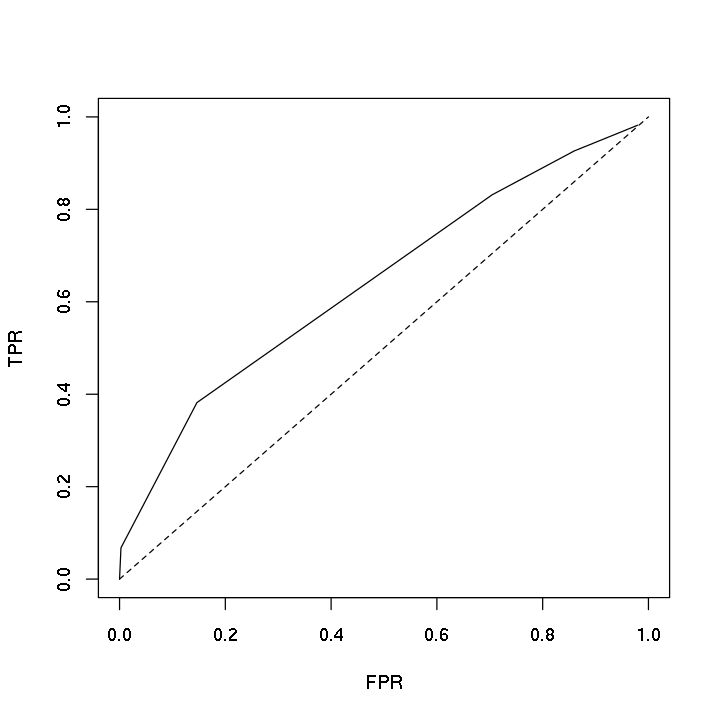

In [257]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(NFP.cllx/sum(!Adj.S[diag(q)!=1])/m,
      NTP.cllx/sum(Adj.S[diag(q)!=1])/m, col='black')
# lines(NFP.S[4,]/sum(!Adj.S), NTP.S[4,]/sum(Adj.S), col='green')
# legend('bottomright', legend=round(lambdas2,digits=3), lty=c(1,1,1,1),
#        col=c('black','blue','red','green'))

## Lee & Liu. (2015).

In [258]:
# lambdas1 = log(p)*c(0.003, 0.01, 0.03, 0.1, 0.3, 0.5, 1)
# lambdas2 = log(p)*c(0.003, 0.01, 0.03, 0.1, 0.3, 0.5, 1)

In [272]:
lambdas1 = log(p)*c(0.1)
lambdas2 = log(p)*c(0.003, 0.005, 0.007, 0.01, 0.02, 0.03)

In [269]:
# est.S.ll.old = est.S.ll

In [273]:
est.S.ll = est.spatial.ll(data.whiten, lambdas1, lambdas2, verbose=TRUE)

regress lambda1: 0.460517 lambda2: 0.01381551 
regress lambda1: 0.460517 lambda2: 0.02302585 
regress lambda1: 0.460517 lambda2: 0.03223619 
regress lambda1: 0.460517 lambda2: 0.0460517 
regress lambda1: 0.460517 lambda2: 0.0921034 
regress lambda1: 0.460517 lambda2: 0.1381551 


In [274]:
A.hat.ll = lapply(est.S.ll$W.hat.S, function(W){
    A.hat = (abs(W) > 1e-5)
    A.hat[diag(q)==1] = FALSE
    return(1 * A.hat)
})

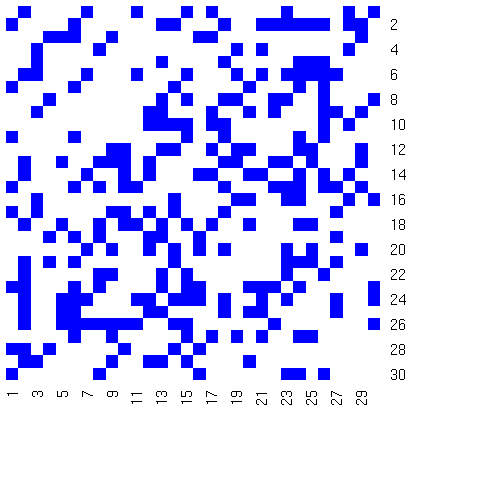

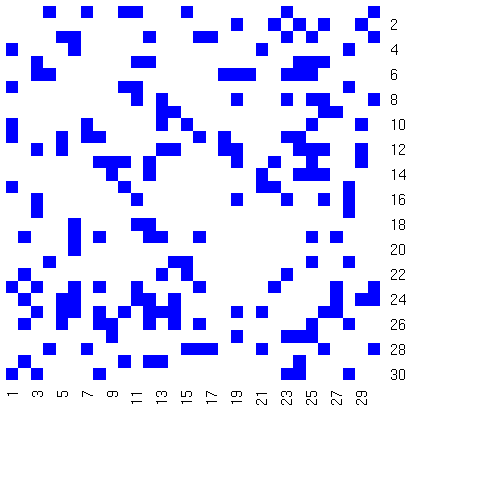

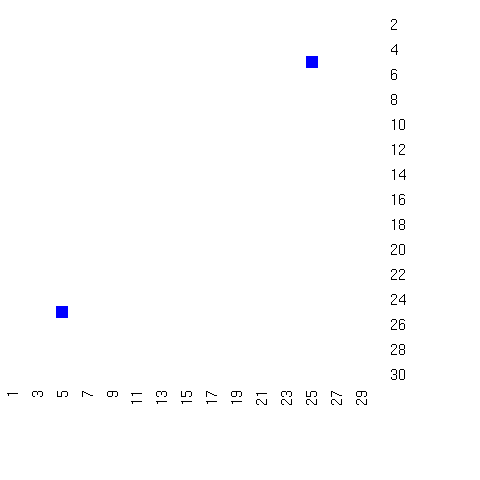

In [275]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(A.hat.ll[[1]][,,1,4])
imshow(A.hat.ll[[1]][,,1,5])

In [276]:
NTP.ll = Reduce(f='+', lapply(A.hat.ll, function(A){
    apply(c(Adj.S) & A, c(3,4), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

In [277]:
NFP.ll = Reduce(f='+', lapply(A.hat.ll, function(A){
    apply(c(!Adj.S) & A, c(3,4), function(X){
    sum(X[diag(q)!=1])
})}), accumulate=FALSE)

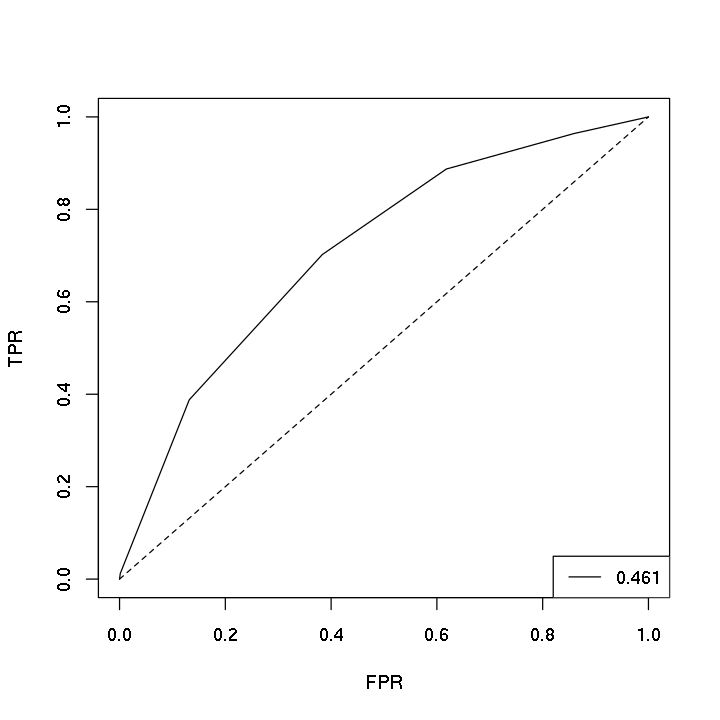

In [282]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(c(1, NFP.ll[1,]/sum(!Adj.S[diag(q)!=1])/m),
      c(1, NTP.ll[1,]/sum(Adj.S[diag(q)!=1])/m), col='black')
# lines(NFP.ll[5,]/sum(!Adj.S[diag(q)!=1])/m, 
#       NTP.ll[5,]/sum(Adj.S[diag(q)!=1])/m, col='blue')
# lines(NFP.ll[6,]/sum(!Adj.S[diag(q)!=1])/m, 
#       NTP.ll[6,]/sum(Adj.S[diag(q)!=1])/m, col='red')
# lines(NFP.ll[7,]/sum(!Adj.S[diag(q)!=1])/m, 
#       NTP.ll[7,]/sum(Adj.S[diag(q)!=1])/m, col='green')
legend('bottomright', legend=round(lambdas1[1],digits=3), lty=c(1,1,1,1),
       col=c('black','blue','red','green'))

# 6. Comparison of ROC curves

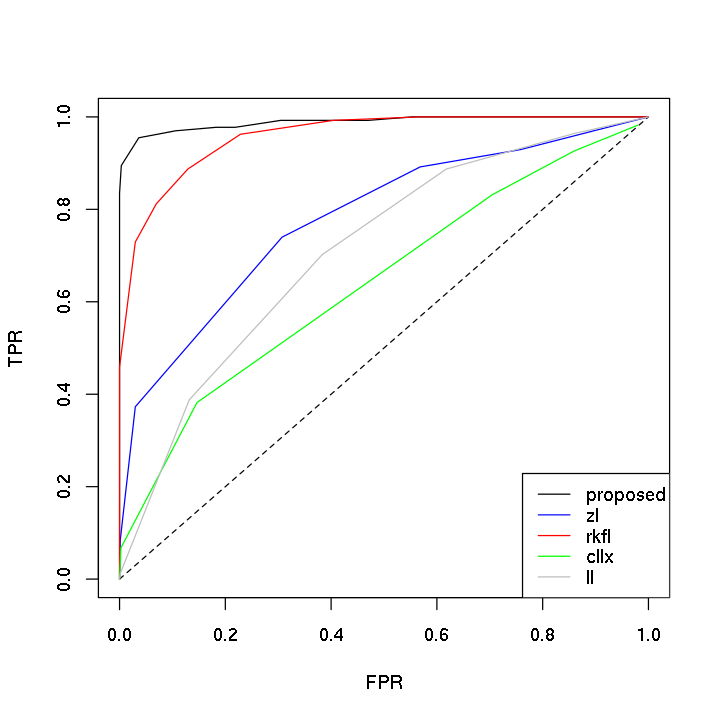

In [285]:
options(repr.plot.width=6, repr.plot.height=6)
plot(c(0,1), c(0,1), type='l', lty=2, xlab="FPR", ylab="TPR")
lines(NFP.S[1,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.S[1,]/sum(Adj.S[diag(q)!=1]), col='black')
lines(NFP.zl[2,]/sum(!Adj.S[diag(q)!=1])/m, 
      NTP.zl[2,]/sum(Adj.S[diag(q)!=1])/m, col='blue')
lines(NFP.rkfl[1,]/sum(!Adj.S[diag(q)!=1]), 
      NTP.rkfl[1,]/sum(Adj.S[diag(q)!=1]), col='red')
lines(NFP.cllx/sum(!Adj.S[diag(q)!=1])/m, 
      NTP.cllx/sum(Adj.S[diag(q)!=1])/m, col='green')
lines(c(1, NFP.ll[1,]/sum(!Adj.S[diag(q)!=1])/m),
      c(1, NTP.ll[1,]/sum(Adj.S[diag(q)!=1])/m), col='grey')
legend('bottomright', legend=c("proposed", "zl","rkfl","cllx","ll"),
       lty=c(1,1,1,1,1),col=c('black','blue','red','green','grey'))